In [91]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

### Data

In [2]:
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

In [3]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

#### Column Descriptions  :


- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.



#### Train dataset

In [4]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
train.isna().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [6]:
print(f'Number of rows in training dataset = {train.shape[0]}')
print(f'Number of columns in training dataset = {train.shape[1]}')
print(f'Number of datapoints in training dataset = {train.count().sum()}')
print(f'Number of missing values in training dataset = {train.isnull().sum().sum()}')

Number of rows in training dataset = 8693
Number of columns in training dataset = 14
Number of datapoints in training dataset = 119378
Number of missing values in training dataset = 2324


#### Test Dataset

In [7]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [8]:
test.isna().sum().sort_values(ascending=False)

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64

In [9]:
print(f'Number of rows in training dataset = {test.shape[0]}')
print(f'Number of columns in training dataset = {test.shape[1]}')
print(f'Number of datapoints in training dataset = {test.count().sum()}')
print(f'Number of missing values in training dataset = {test.isnull().sum().sum()}')

Number of rows in training dataset = 4277
Number of columns in training dataset = 13
Number of datapoints in training dataset = 54484
Number of missing values in training dataset = 1117


In [10]:
print(f'Duplicates in Train Dataset : {train.duplicated().sum()}')
print(f'Duplicates in Test Dataset : {train.duplicated().sum()}')

Duplicates in Train Dataset : 0
Duplicates in Test Dataset : 0


In [11]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [12]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### EDA

#### Target Feature

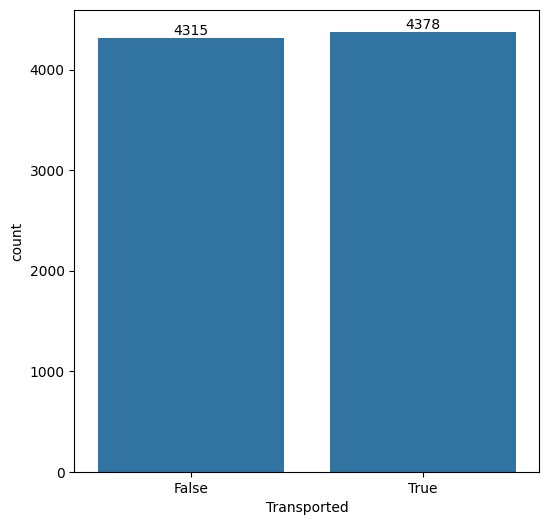

In [13]:
plt.figure(figsize=(6,6))
ax = sns.barplot(train['Transported'].value_counts())
ax.bar_label(ax.containers[0])
plt.show()

#### Age

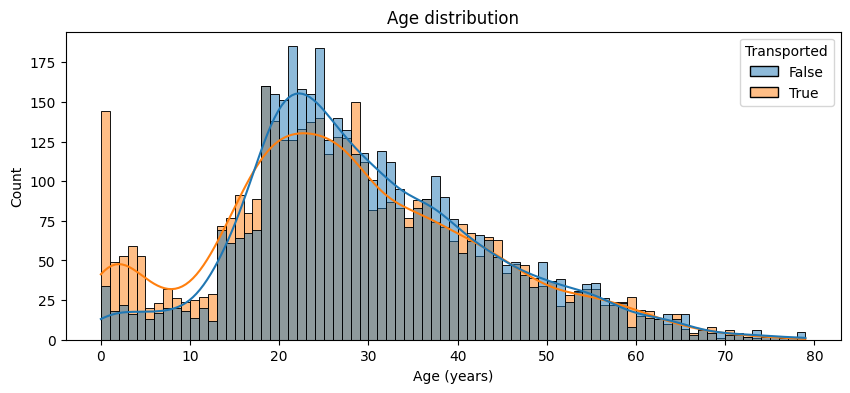

In [14]:
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Age distribution')
plt.xlabel('Age (years)')
plt.show()

#### Expenditure Feature

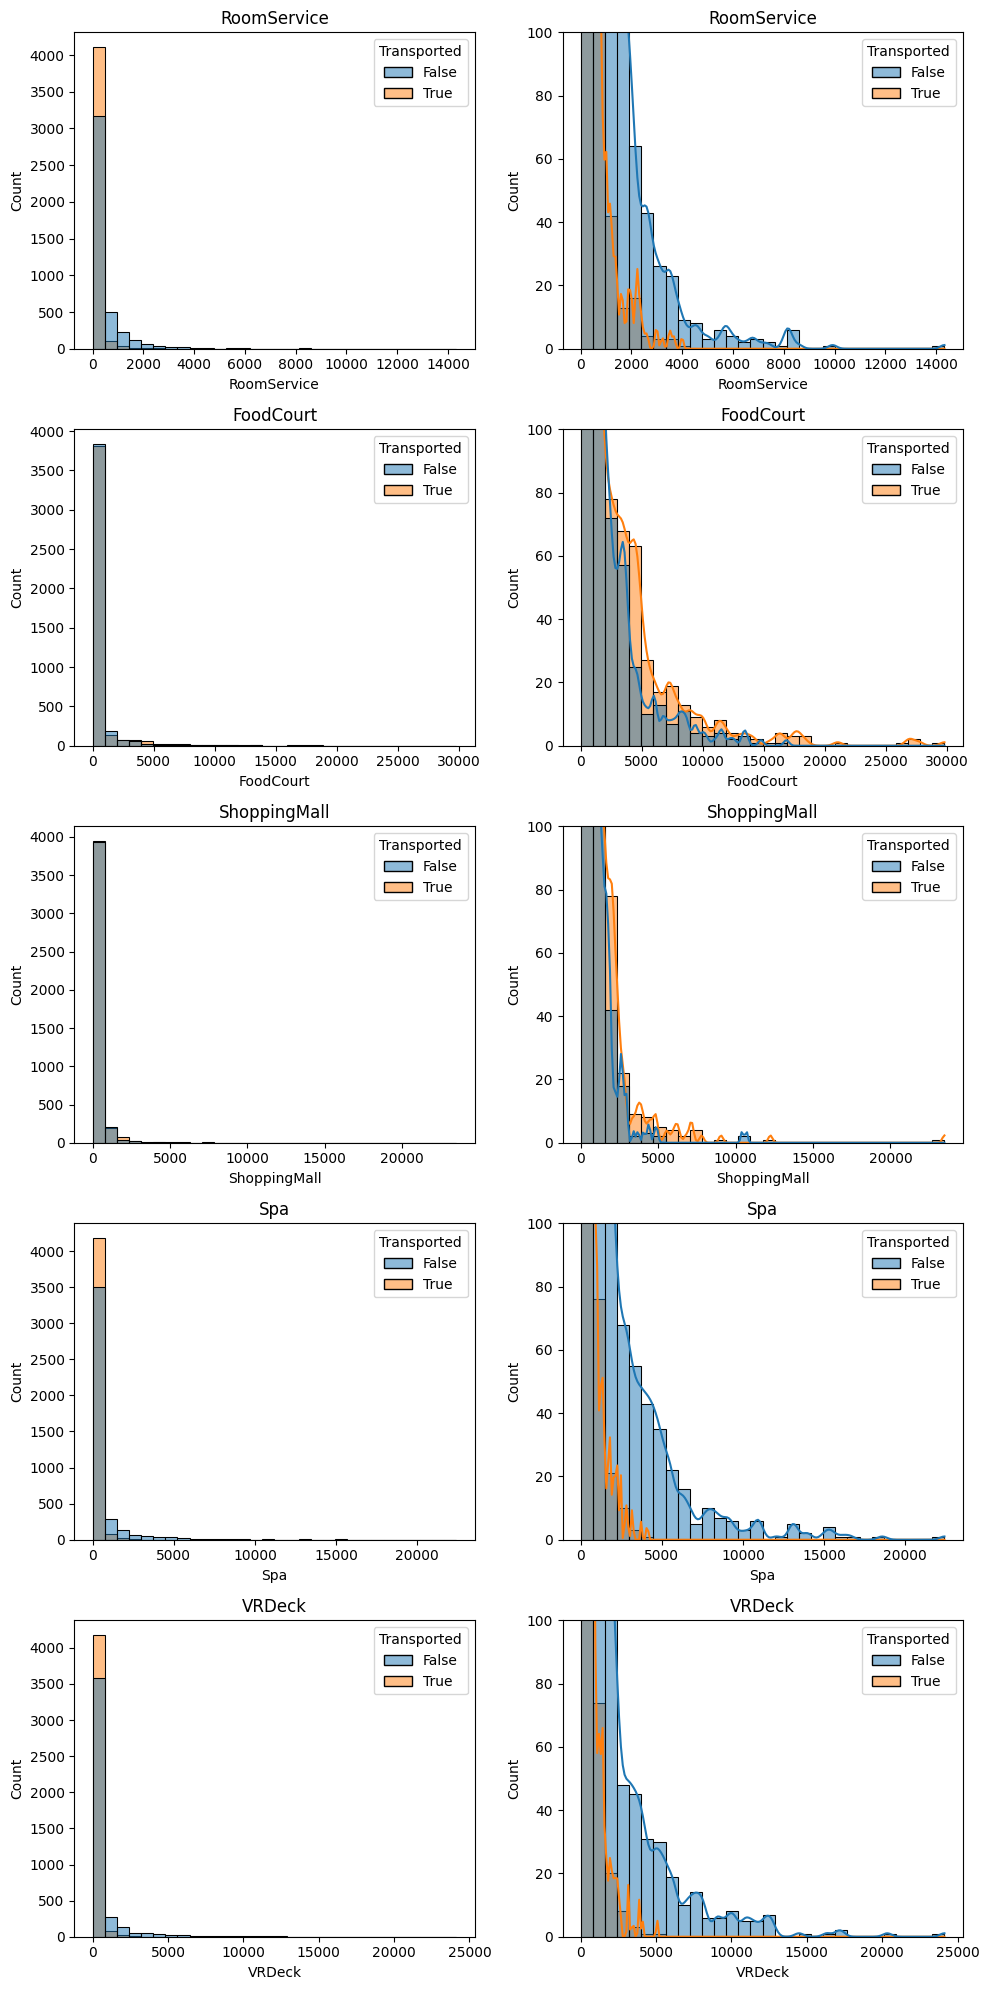

In [15]:
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_features):
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#### Categorical Feature

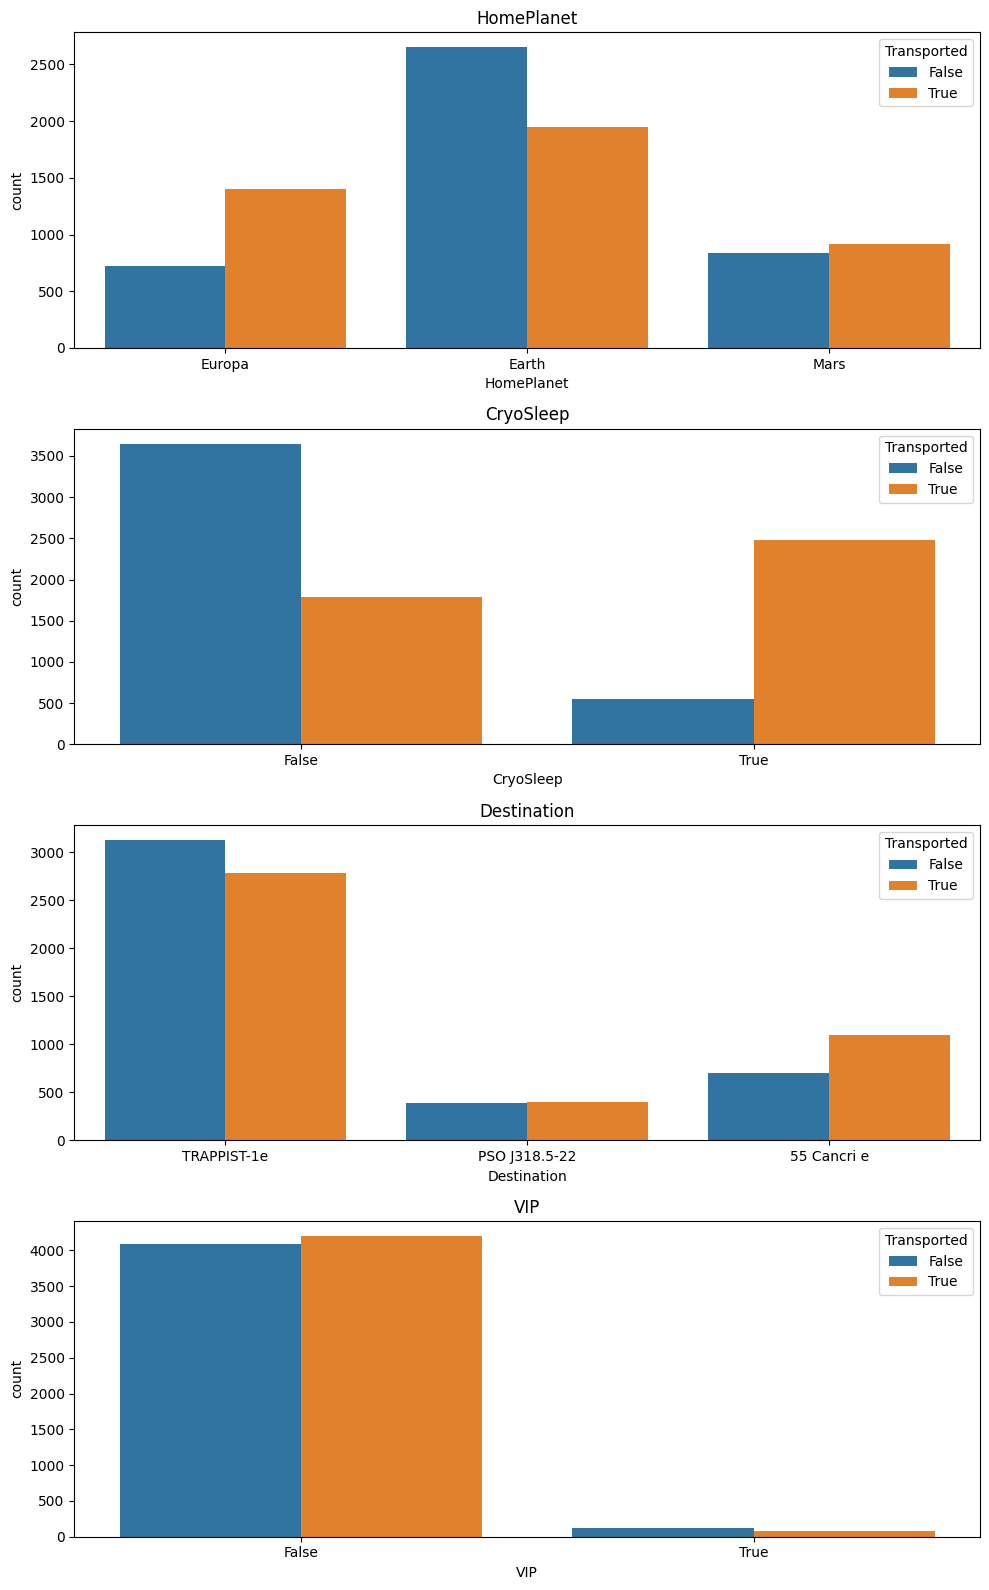

In [16]:
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#### Qualitative features


In [17]:
qual_feats=['PassengerId', 'Cabin' ,'Name']
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


### Feature Engineering

The philosophy to feature engineering is simple. ***Better features make better models.***

In [18]:
def age_group(df):
    df['Age_group'] = np.nan
    df.loc[df['Age']<=12, 'Age_group'] = 'Age_0-12'
    df.loc[(df['Age']>12) & (df['Age']<18), 'Age_group'] = 'Age_13-17'
    df.loc[(df['Age']>=18) & (df['Age']<=25), 'Age_group'] = 'Age_18-25'
    df.loc[(df['Age']>25) & (df['Age']<=30), 'Age_group'] = 'Age_26-30'
    df.loc[(df['Age']>30) & (df['Age']<=50), 'Age_group'] = 'Age_31-50'
    df.loc[df['Age']>50, 'Age_group'] = 'Age_51+'
    return df

In [19]:
train = age_group(train)
test = age_group(test)

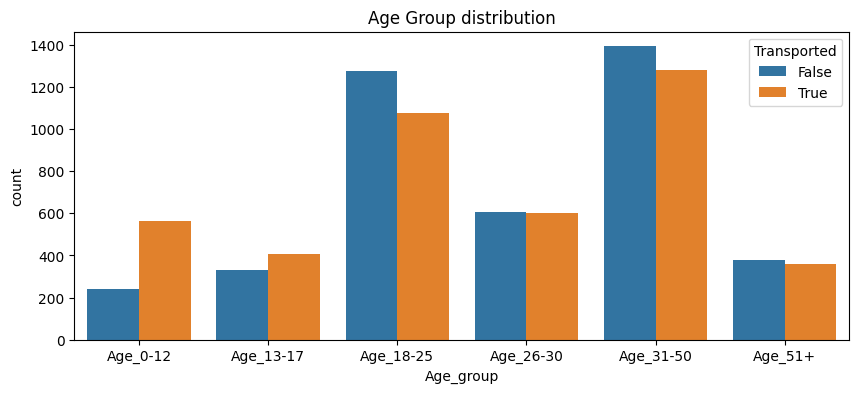

In [20]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17', 'Age_18-25', 'Age_26-30','Age_31-50', 'Age_51+'])
plt.title('Age Group distribution')
plt.show()

In [21]:
def expenditure(df):
    df['Expenditure'] = df[exp_features].sum(axis=1)
    df['No_spending'] = (df['Expenditure']==0).astype(int)
    return df

In [22]:
train = expenditure(train)
test = expenditure(test)

In [23]:
train['Expenditure'].describe()

count     8693.000000
mean      1440.866329
std       2803.045694
min          0.000000
25%          0.000000
50%        716.000000
75%       1441.000000
max      35987.000000
Name: Expenditure, dtype: float64

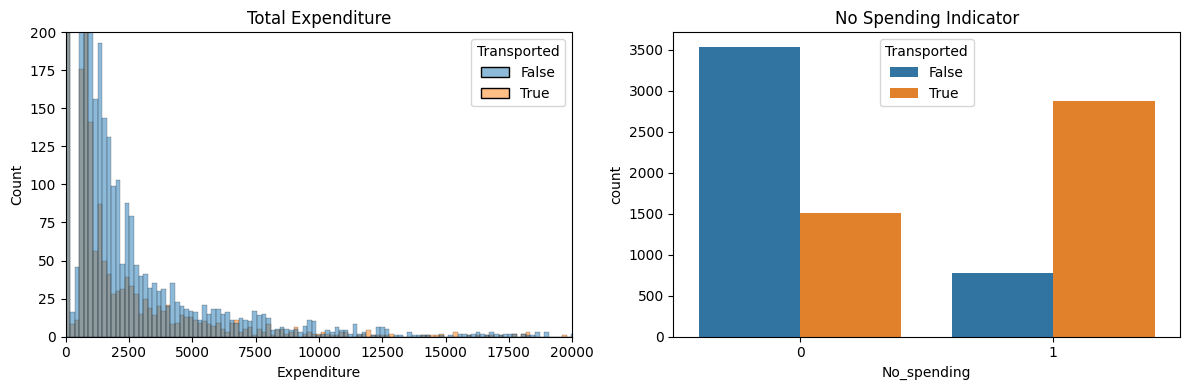

In [24]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total Expenditure')
plt.ylim([0, 200])
plt.xlim([0, 20000])
plt.subplot(1, 2, 2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No Spending Indicator')
plt.tight_layout()
plt.show()

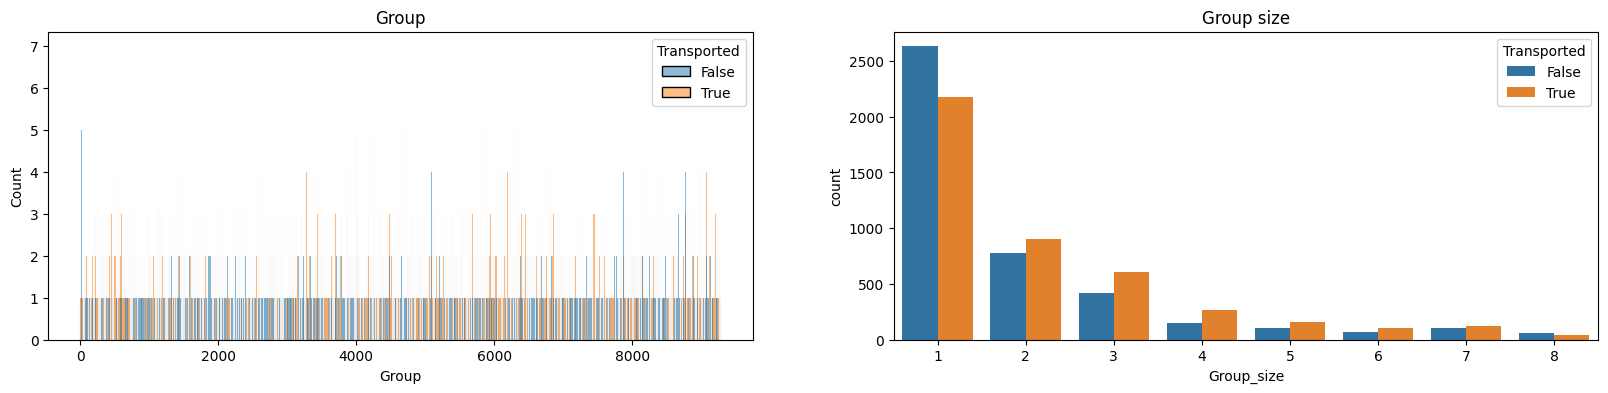

In [25]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

In [26]:
def travelling_solo_or_not(df):
    df['Solo'] = (df['Group_size'] == 1).astype(int)
    return df

In [27]:
train = travelling_solo_or_not(train)
test = travelling_solo_or_not(test)

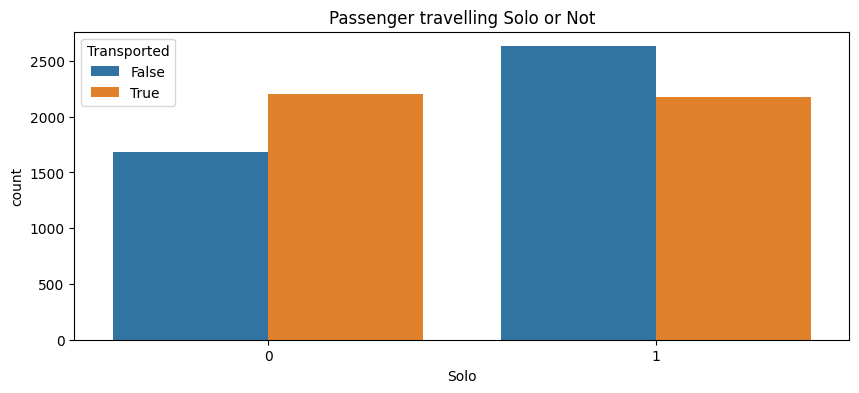

In [28]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x = 'Solo', hue='Transported')
plt.title('Passenger travelling Solo or Not')
plt.show()

In [29]:
def cabin_extract(df):
    df['Cabin'].fillna('Z/9999/Z', inplace = True)
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['Cabin_number'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    df['Cabin_side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df.loc[df['Cabin_deck']=='Z', 'Cabin_deck'] = np.nan
    df.loc[df['Cabin_number']==9999, 'Cabin_number'] = np.nan
    df.loc[df['Cabin_side']=='Z', 'Cabin_side'] = np.nan
    df.drop('Cabin', axis = 1, inplace = True)
    return df

In [30]:
train = cabin_extract(train)
test = cabin_extract(test)

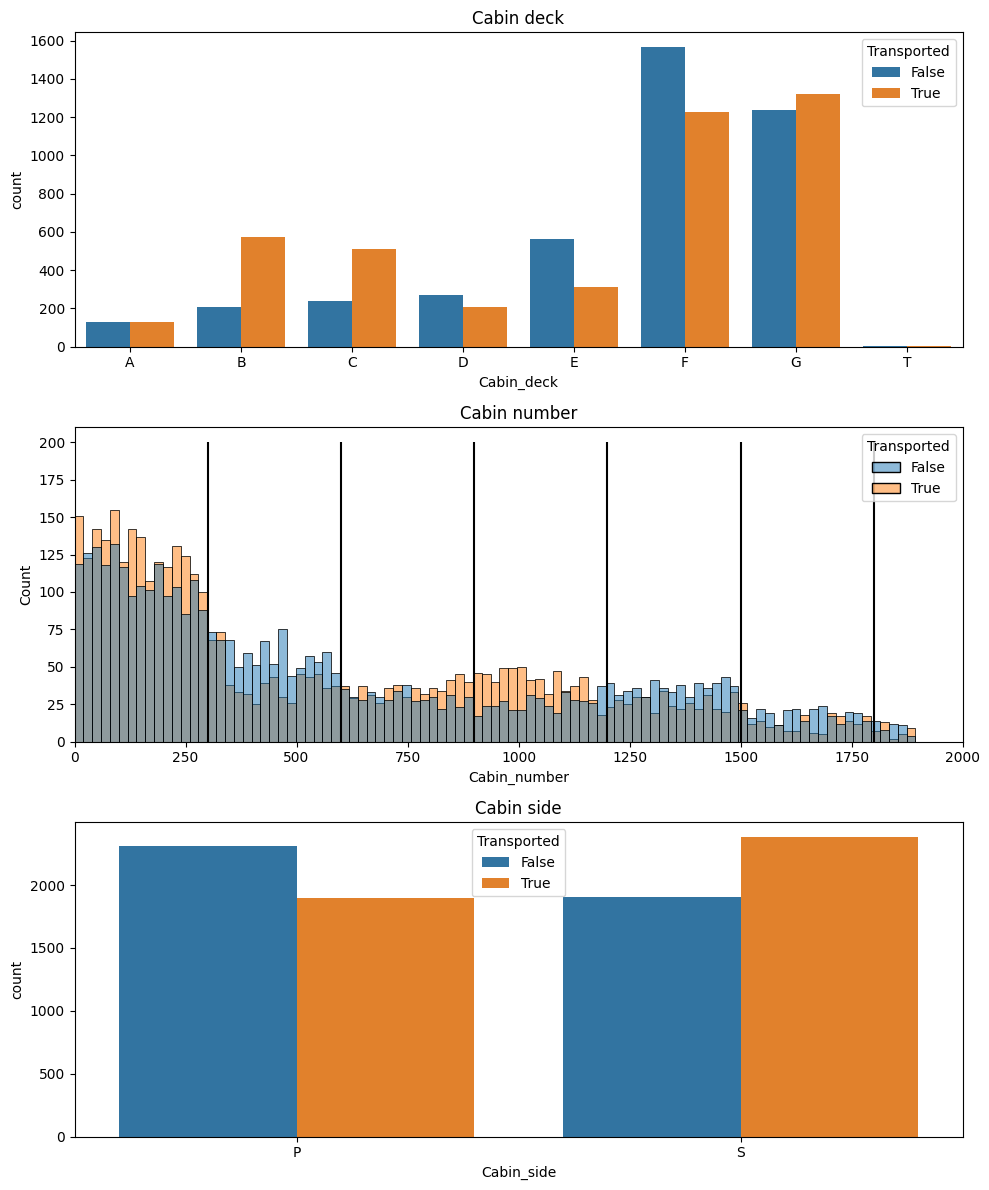

In [31]:
fig = plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

In [32]:
def cabin_region(df):
    df['Cabin_region1'] = (df['Cabin_number']<300).astype(int)
    df['Cabin_region2'] = ((df['Cabin_number']>=300) & (df['Cabin_number']<600)).astype(int)
    df['Cabin_region3'] = ((df['Cabin_number']>=600) & (df['Cabin_number']<900)).astype(int)
    df['Cabin_region4'] = ((df['Cabin_number']>=900) & (df['Cabin_number']<1200)).astype(int)
    df['Cabin_region5'] = ((df['Cabin_number']>=1200) & (df['Cabin_number']<1500)).astype(int)
    df['Cabin_region6'] = ((df['Cabin_number']>=1500) & (df['Cabin_number']<1800)).astype(int)
    df['Cabin_region7'] = (df['Cabin_number']>=1800).astype(int)
    return df

In [33]:
train = cabin_region(train)
test = cabin_region(test)

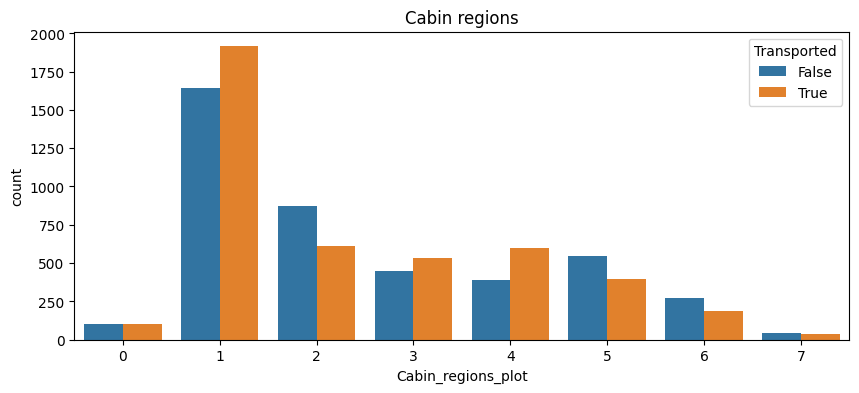

In [34]:
plt.figure(figsize=(10, 4))
train['Cabin_regions_plot']=(train['Cabin_region1']+
                             2*train['Cabin_region2']+
                             3*train['Cabin_region3']+
                             4*train['Cabin_region4']+
                             5*train['Cabin_region5']+
                             6*train['Cabin_region6']+
                             7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

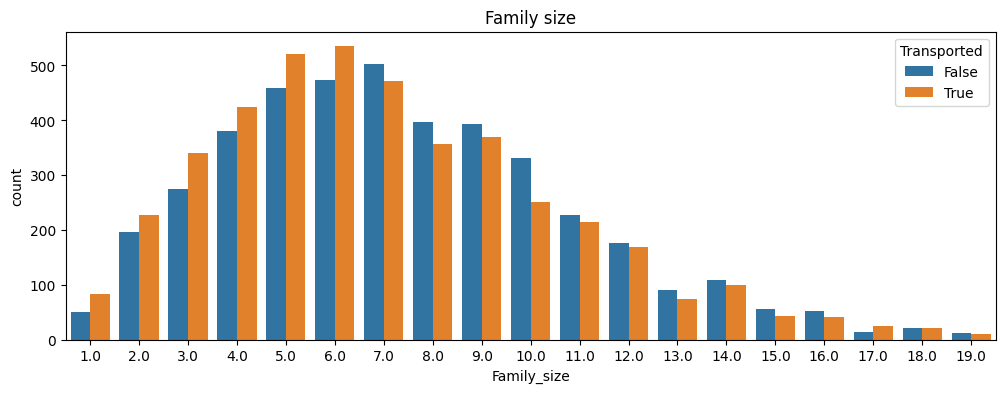

In [35]:
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')
plt.show()

In [36]:
train.shape, test.shape

((8693, 30), (4277, 29))

#### Missing Value Imputation

In [37]:
y = train['Transported'].copy().astype(int)
X = train.drop('Transported', axis=1).copy()

In [38]:
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [39]:
na_cols=data.columns[data.isna().any()].tolist()

mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Text(0.5, 1.0, 'Heatmap of missing values')

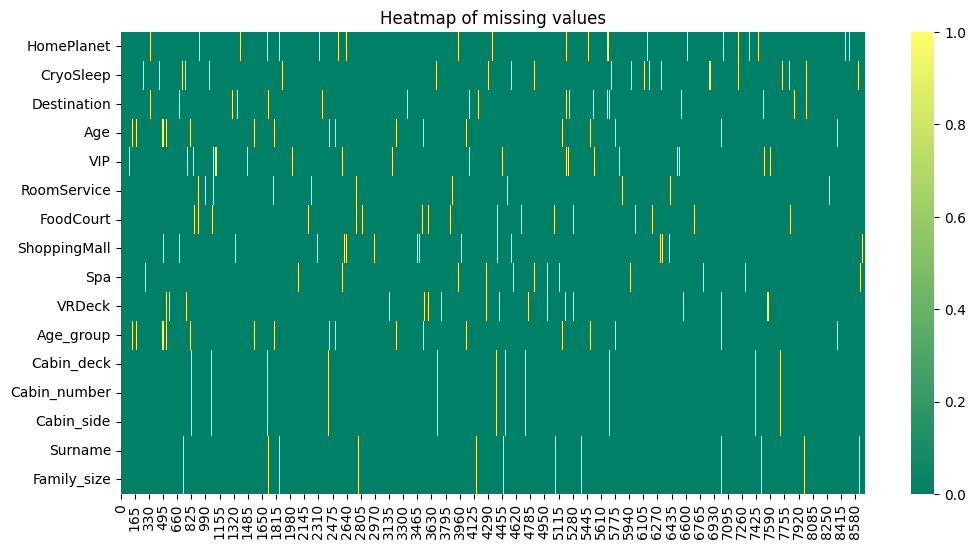

In [40]:
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

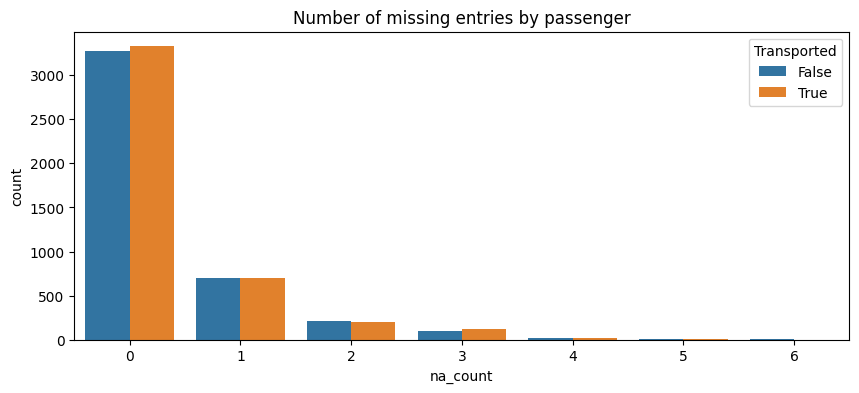

In [41]:
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

***Median for Continuous Variable***

***Mode for Categorical features***

#### Homeplanet and Group

In [42]:
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


In [43]:
data['HomePlanet'].isna().sum()

288

In [44]:
HP_bef = data['HomePlanet'].isna().sum()
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

print(f'HomePlanet missing values before:{HP_bef}')
print(f'HomePlanet missing values after:{data['HomePlanet'].isna().sum()}')

HomePlanet missing values before:288
HomePlanet missing values after:157


#### HomePlanet and CabinDeck

<Axes: xlabel='Cabin_deck', ylabel='HomePlanet'>

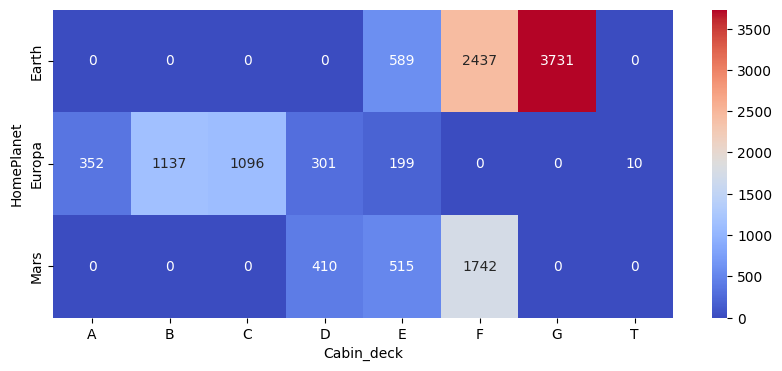

In [45]:
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [46]:
HP_bef=data['HomePlanet'].isna().sum()

data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

print(f'HomePlanet missing values before:{HP_bef}')
print(f'#HomePlanet missing values after:{data['HomePlanet'].isna().sum()}')

HomePlanet missing values before:157
#HomePlanet missing values after:94


#### Homeplanet and Surname

In [47]:
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

In [48]:
HP_bef=data['HomePlanet'].isna().sum()

SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

print(f'HomePlanet missing values before:{HP_bef}')
print(f'HomePlanet missing values after:{data['HomePlanet'].isna().sum()}')

HomePlanet missing values before:94
HomePlanet missing values after:10


In [49]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


<Axes: xlabel='HomePlanet', ylabel='Destination'>

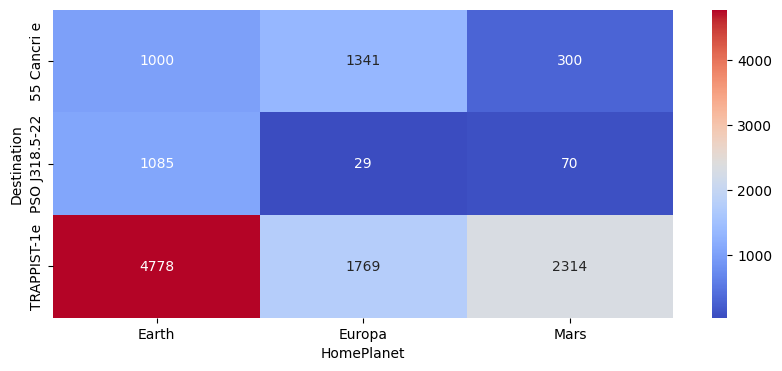

In [50]:
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [51]:
HP_bef=data['HomePlanet'].isna().sum()

data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

print(f'HomePlanet missing values before:{HP_bef}')
print(f'HomePlanet missing values after:{data['HomePlanet'].isna().sum()}')

HomePlanet missing values before:10
HomePlanet missing values after:0


#### Destination

In [52]:
D_bef=data['Destination'].isna().sum()

data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

print(f'Destination missing values before:{D_bef}')
print(f'Destination missing values after:{data['Destination'].isna().sum()}')

Destination missing values before:274
Destination missing values after:0


#### Surname and Group

In [53]:
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

In [54]:
SN_bef=data['Surname'].isna().sum()

GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

print(f'Surname missing values before:{SN_bef}')
print(f'Surname missing values after:{data['Surname'].isna().sum()}')

Surname missing values before:294
Surname missing values after:155


In [55]:
data['Surname'].fillna('Unknown', inplace=True)

data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

data.loc[data['Surname']=='Unknown','Surname']=np.nan

data.loc[data['Family_size']>100,'Family_size']=0

In [56]:
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

In [57]:
CS_bef=data['Cabin_side'].isna().sum()

GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

print(f'Cabin_side missing values before:{CS_bef}')
print(f'Cabin_side missing values after:{data['Cabin_side'].isna().sum()}')

Cabin_side missing values before:299
Cabin_side missing values after:162


Text(0.5, 1.0, 'Ratio of cabin side by surname')

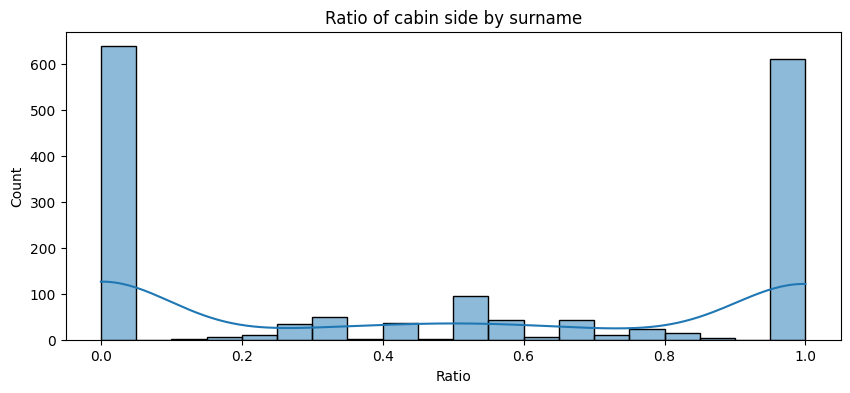

In [58]:
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [59]:
print(f'Percentage of families all on the same cabin side:{100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3)}%')

SCS_gb.head()

Percentage of families all on the same cabin side:76.7%


Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


In [60]:
CS_bef=data['Cabin_side'].isna().sum()

SCS_gb.drop('Ratio', axis=1, inplace=True)

SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

data.drop('Surname', axis=1, inplace=True)

print(f'Cabin_side missing values before:,{CS_bef}')
print(f'Cabin_side missing values after:{data['Cabin_side'].isna().sum()}')

Cabin_side missing values before:,162
Cabin_side missing values after:66


In [61]:
data['Cabin_side'].value_counts()

Cabin_side
S    6504
P    6400
Name: count, dtype: int64

In [62]:
CS_bef=data['Cabin_side'].isna().sum()

data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

print(f'Cabin_side missing values before:{CS_bef}')
print(f'Cabin_side missing values after:{data['Cabin_side'].isna().sum()}')

Cabin_side missing values before:66
Cabin_side missing values after:0


In [63]:
CD_bef=data['Cabin_deck'].isna().sum()

GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

print(f'Cabin_deck missing values before:{CD_bef}')
print(f'Cabin_deck missing values after:{data['Cabin_deck'].isna().sum()}')

Cabin_deck missing values before:299
Cabin_deck missing values after:162


In [64]:
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

In [65]:
CD_bef=data['Cabin_deck'].isna().sum()

na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

print(f'Cabin_deck missing values before:{CD_bef}')
print(f'Cabin_deck missing values after:{data['Cabin_deck'].isna().sum()}')

Cabin_deck missing values before:162
Cabin_deck missing values after:0


Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

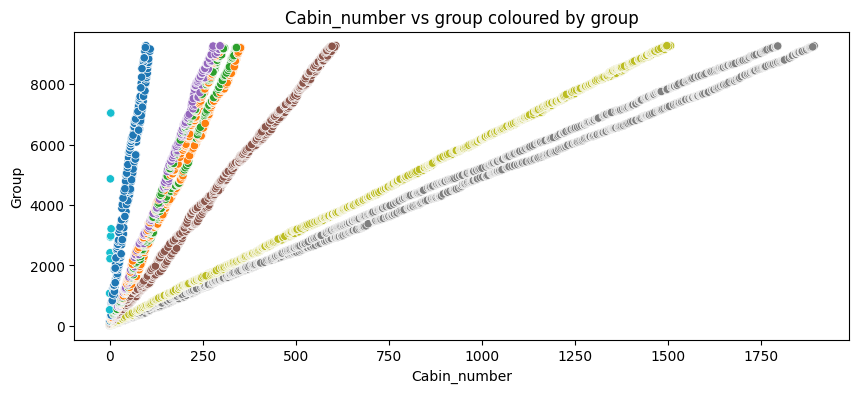

In [66]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

In [67]:
CN_bef=data['Cabin_number'].isna().sum()

for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

print(f'Cabin_number missing values before:{CN_bef}')
print(f'Cabin_number missing values after:{data['Cabin_number'].isna().sum()}')

Cabin_number missing values before:299
Cabin_number missing values after:0


In [68]:
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

In [69]:
data['VIP'].value_counts()

VIP
False    12401
True       273
Name: count, dtype: int64

In [70]:
V_bef=data['VIP'].isna().sum()

data.loc[data['VIP'].isna(),'VIP']=False

print(f'VIP missing values before:{V_bef}')
print(f'VIP missing values after:{data['VIP'].isna().sum()}')

VIP missing values before:296
VIP missing values after:0


In [71]:
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [72]:
A_bef=data[exp_features].isna().sum().sum()

na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

print(f'Age missing values before:{A_bef}')
print(f'Age missing values after:{data['Age'].isna().sum()}')

Age missing values before:1410
Age missing values after:0


In [73]:
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

In [74]:
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [75]:
CSL_bef=data['CryoSleep'].isna().sum()

na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

print(f'CryoSleep missing values before:{CSL_bef}')
print(f'CryoSleep missing values after:{data['CryoSleep'].isna().sum()}')

CryoSleep missing values before:310
CryoSleep missing values after:0


In [76]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_features].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [77]:
E_bef=data[exp_features].isna().sum().sum()

for col in exp_features:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print(f'Expenditure missing values before:{E_bef}')
print(f'Expenditure missing values after:{data[exp_features].isna().sum().sum()}')

Expenditure missing values before:1410
Expenditure missing values after:866


In [78]:
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [79]:
E_bef=data[exp_features].isna().sum().sum()

for col in exp_features:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

print(f'Expenditure missing values before:{E_bef}')
print(f'Expenditure missing values after:{data[exp_features].isna().sum().sum()}')

Expenditure missing values before:866
Expenditure missing values after:0


In [80]:
data['Expenditure']=data[exp_features].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

In [81]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

### Preprocessing

In [82]:
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [83]:
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

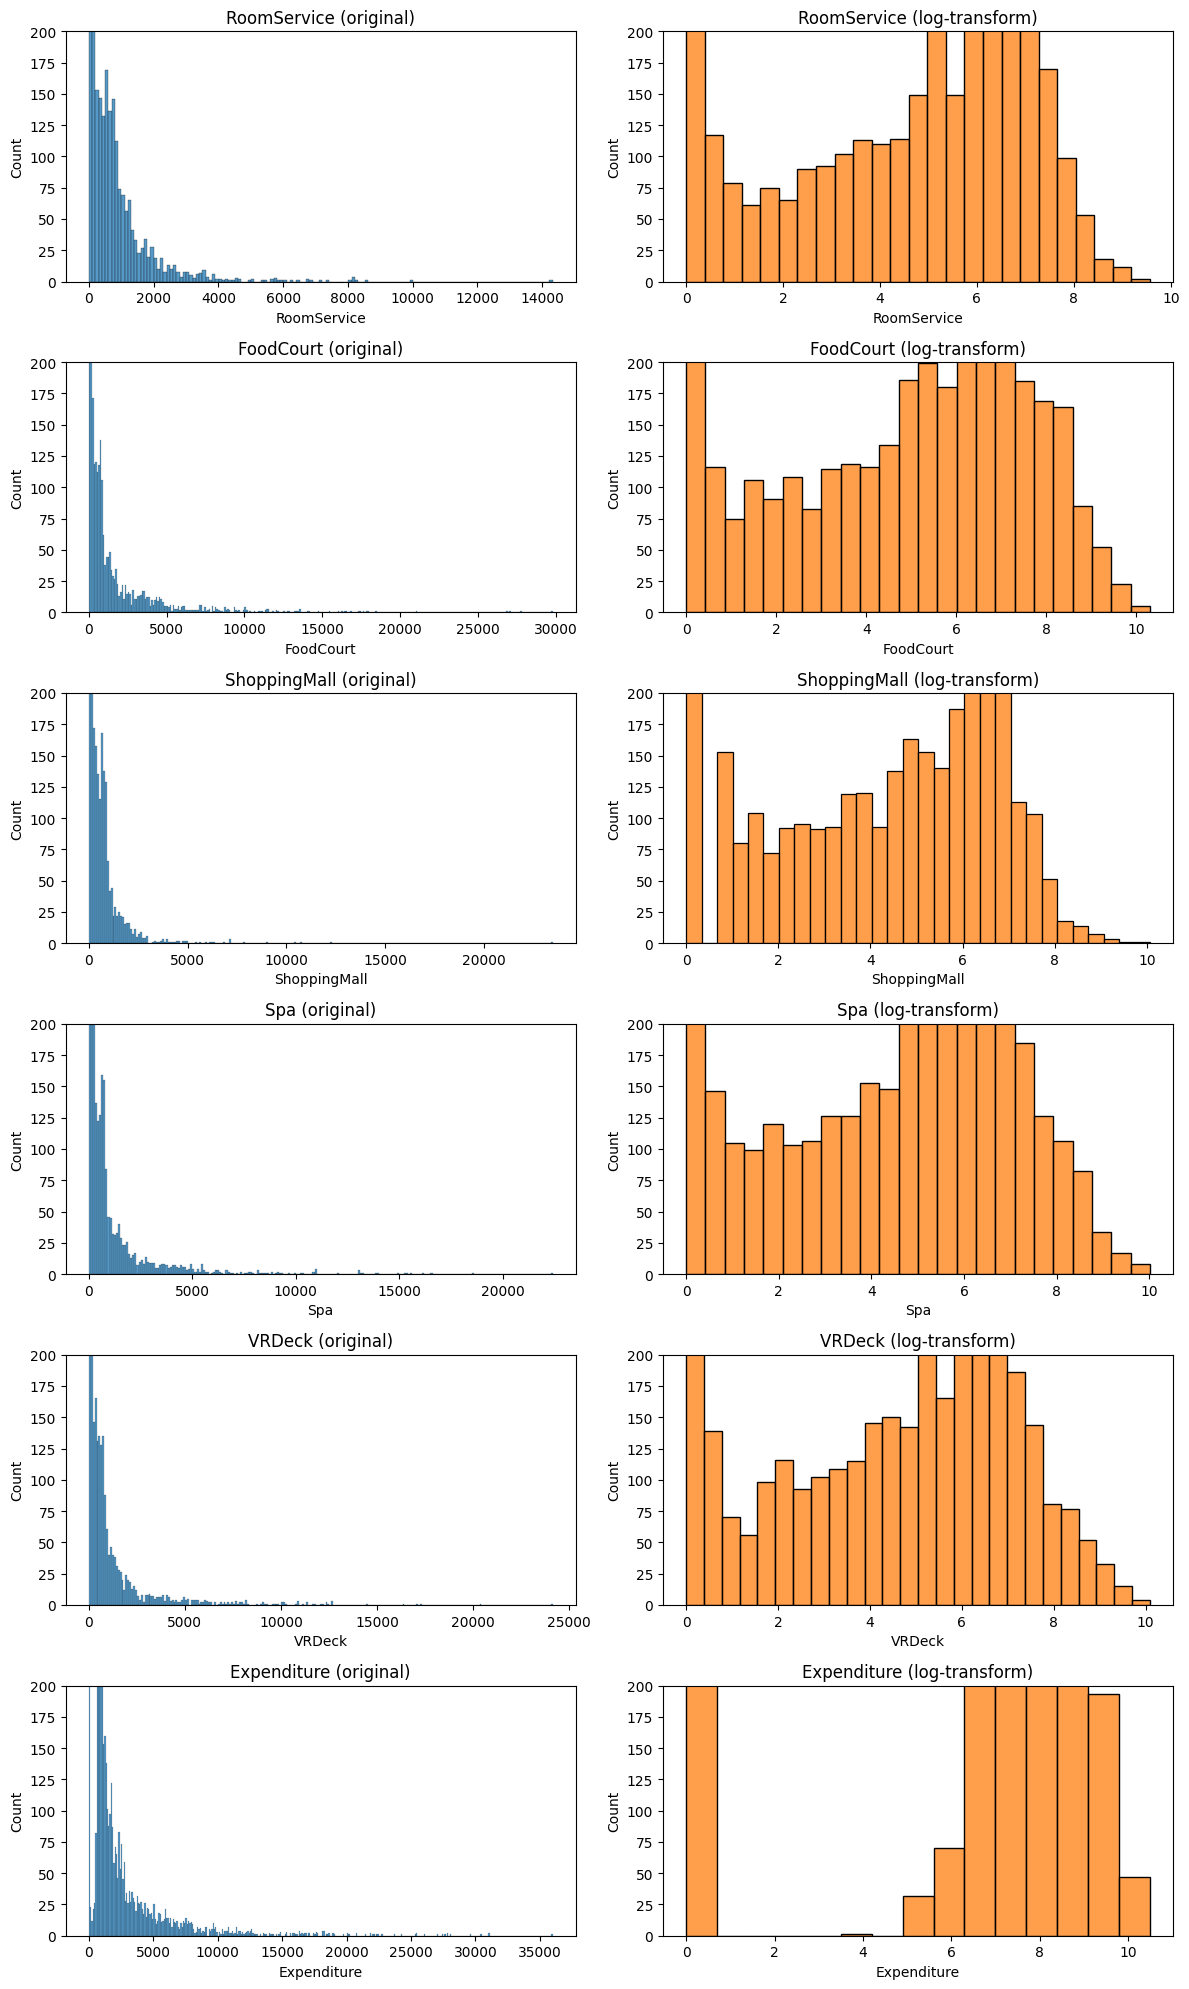

In [84]:
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [85]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [86]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

X = ct.fit_transform(X)
X_test = ct.transform(X_test)

print('Training set shape:', X.shape)

Training set shape: (8693, 36)


#### PCA

In [87]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum()*100

fig = px.scatter_3d(components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)),
                    opacity=1, title=f'Total Explained Variance :{total_var:.2f}%',
                    labels={'0':'PC 1', '1':'PC 2', '2':'PC 3'},
                    width=800, height=500)
fig.show()

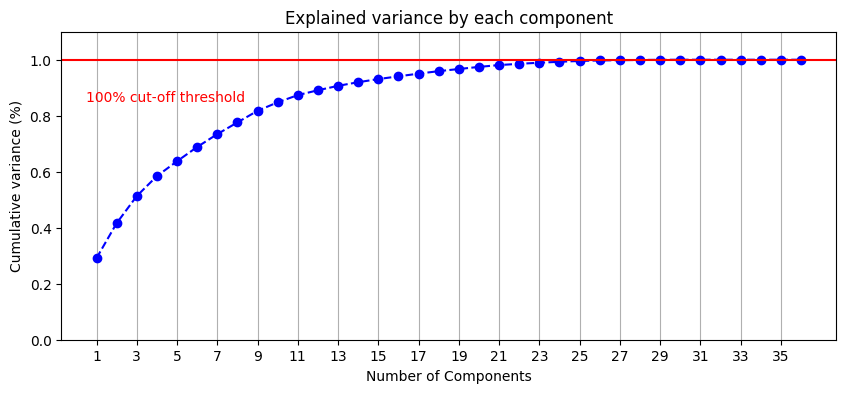

In [88]:
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red')
ax.grid(axis='x')

In [89]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=42)

### Model Selection

In [90]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [92]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: LogisticRegression
Training time (mins): 0.12

Model: KNN
Training time (mins): 0.02

Model: SVC
Training time (mins): 4.16

Model: RandomForest
Training time (mins): 0.26

Model: XGBoost
Training time (mins): 0.4

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No furth

In [93]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.785509,0.12
1,KNN,0.788959,0.02
2,SVC,0.802185,4.16
3,RandomForest,0.798160,0.26
4,XGBoost,0.818286,0.40
5,LGBM,0.822887,0.26
6,CatBoost,0.814836,10.29
7,NaiveBayes,0.747556,0.00


LGBM, XGboost, CatBoost

In [94]:
clf_best_params

{'LogisticRegression': {'C': 0.5, 'max_iter': 100, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 7, 'p': 1},
 'SVC': {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 10, 'n_estimators': 300},
 'XGBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200},
 'NaiveBayes': {'var_smoothing': 1e-07}}

In [95]:
# Classifiers
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=0),
    'XGBoost' : XGBClassifier(**clf_best_params['XGBoost'])
}

In [96]:
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        clf = classifier
        clf.fit(X_train, y_train)

        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)

    score=score/FOLDS

    stop = time.time()
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3940, number of negative: 3883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 7823, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503643 -> initscore=0.014573
[LightGBM] [Info] Start training from score 0.014573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Text(0.5, 0, 'Probability')

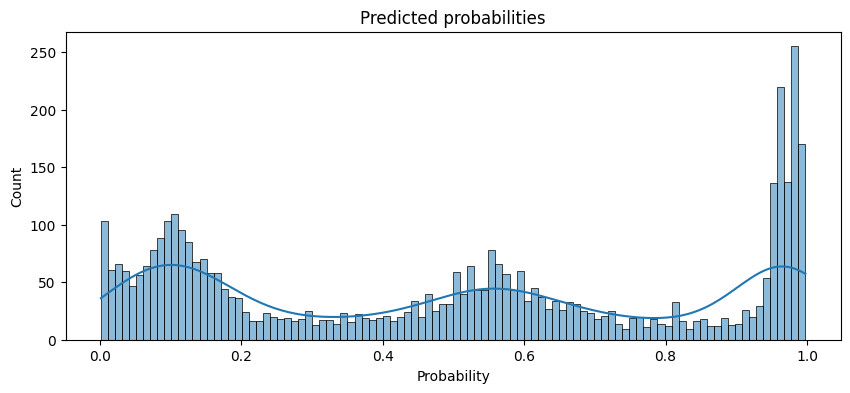

In [97]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [98]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

52.75


Optimal threshold: 0.506


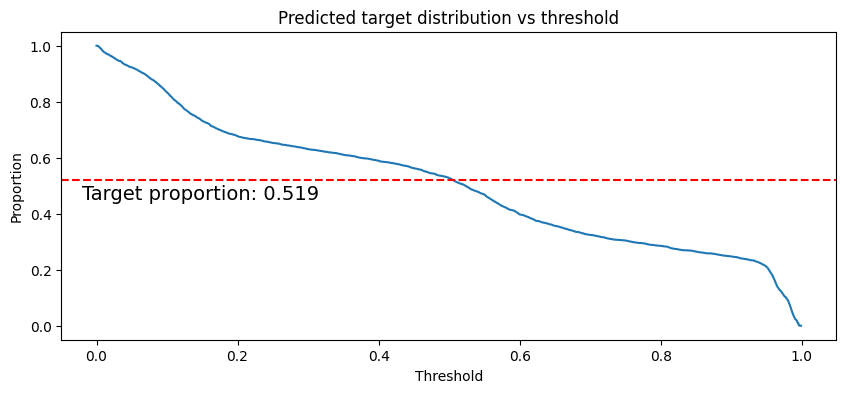

In [99]:
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

def plot_preds_prop(preds_arr):
    T_array=np.arange(0,1,0.001)
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.519         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [100]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

Text(0.5, 1.0, 'Prediction distribution')

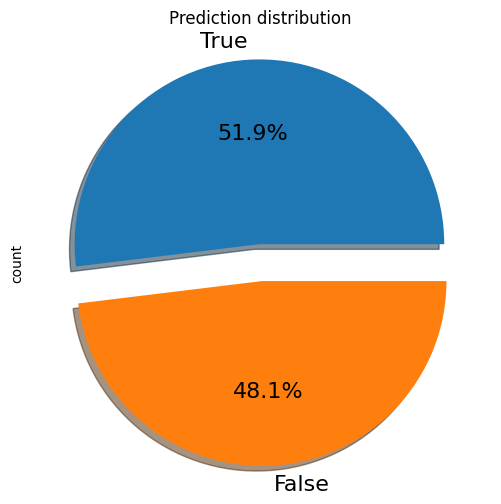

In [101]:
sub=pd.read_csv('../dataset/sample_submission.csv')

sub['Transported']=preds_tuned

sub=sub.replace({0:False, 1:True})

plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [102]:
sub.to_csv('../submission/submission.csv', index=False)